In [8]:
import numpy as np
import torch
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
import sys

if "../model" not in sys.path:
    sys.path.insert(0, "../model")

from typing import Any

In [10]:
coco_root = Path("/home/dherrera/data/coco")
data_file = coco_root / "annotations/elephants_train2017.json"
coco_json: dict[str, Any] = json.load(data_file.open())

In [12]:
display(coco_json.keys())
display(coco_json["images"][0])
display(coco_json["annotations"][0])
coco_categories = coco_json["categories"]
display(coco_categories)

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

{'license': 3,
 'file_name': '000000384553.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000384553.jpg',
 'height': 425,
 'width': 640,
 'date_captured': '2013-11-14 21:45:37',
 'flickr_url': 'http://farm5.staticflickr.com/4006/4581234593_5802cfe86f_z.jpg',
 'id': 384553}

{'segmentation': [[81.1,
   149.74,
   88.61,
   137.03,
   100.74,
   131.25,
   115.18,
   123.17,
   119.8,
   120.28,
   127.3,
   119.7,
   134.24,
   119.12,
   126.73,
   109.31,
   124.99,
   104.11,
   122.68,
   99.49,
   122.11,
   91.4,
   118.06,
   82.74,
   124.42,
   77.54,
   129.62,
   78.69,
   130.19,
   96.02,
   138.28,
   101.8,
   141.74,
   109.88,
   148.1,
   122.01,
   149.83,
   124.32,
   164.27,
   140.5,
   173.51,
   153.78,
   175.82,
   174.0,
   174.67,
   180.93,
   167.74,
   189.59,
   126.15,
   185.55,
   99.58,
   171.11,
   89.76,
   166.49]],
 'area': 5175.1516,
 'iscrowd': 0,
 'image_id': 266853,
 'bbox': [81.1, 77.54, 94.72, 112.05],
 'category_id': 1,
 'id': 580104}

[{'supercategory': 'animal', 'id': 1, 'name': 'elephant'}]

In [5]:
from coco_utils import get_coco

ds = get_coco(
    root="/home/dherrera/data/coco",
    image_set="train",
    transforms=None,
    mode="instances",
    use_v2=False,
    with_masks=True,
)

loading annotations into memory...
Done (t=5.74s)
creating index...
index created!


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


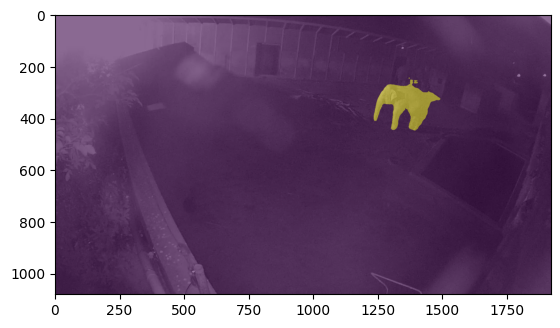

In [6]:
from coco_utils import ConvertCocoPolysToMask, CocoDetection, T

t = [ConvertCocoPolysToMask()]
transforms = T.Compose(t)
ds_ele = CocoDetection(
    "/home/dherrera/data/elephants/training_data",
    "/home/dherrera/data/elephants/training_data/annotations.json",
    transforms=transforms,
)

img, target = ds_ele[0]
plt.imshow(img)
plt.imshow(target["masks"][0], alpha=0.5)

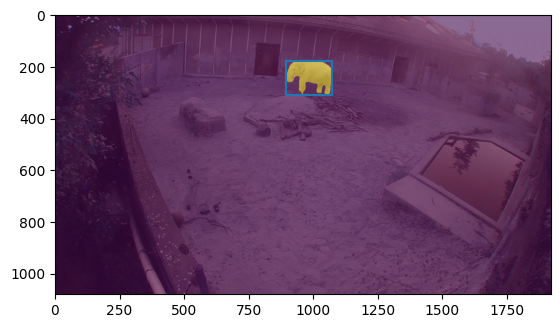

In [7]:
training_data_root = Path("/home/dherrera/data/elephants/training_data")
image_file = (
    training_data_root
    / "Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00000000_img.jpg"
)
segmentation_file = (
    training_data_root
    / "Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00000000_seg.png"
)

image = cv2.imread(image_file)
segmentation = cv2.imread(segmentation_file, flags=cv2.IMREAD_GRAYSCALE)
ids = list(set(np.unique(segmentation)) - {0})
mask = segmentation == ids[0]


def bbox_from_mask(mask) -> tuple[int, int, int, int]:
    mask_rows = np.any(mask, axis=1)
    mask_cols = np.any(mask, axis=0)

    def line_start_size(values):
        start = values.argmax() - 1
        end = values.shape[0] - np.flip(values).argmax() - 1
        return (int(start), int(end - start))

    start_x, size_x = line_start_size(mask_cols)
    start_y, size_y = line_start_size(mask_rows)
    return (start_x, start_y, size_x, size_y)


bbox = bbox_from_mask(mask)
plt.imshow(image)
plt.imshow(mask, alpha=0.5)


def plot_bbox(ax, bbox):
    x0 = bbox[0]
    x1 = bbox[0] + bbox[2]
    y0 = bbox[1]
    y1 = bbox[1] + bbox[3]
    ax.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], "-")


plot_bbox(plt.gca(), bbox)